In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

In [2]:
## Read in the data
df = pd.read_csv('https://raw.githubusercontent.com/CasKirch/MLP-from-scratch/main/churn.csv')
del df['customerID']
del df['MultipleLines'] 
df = df[df.TotalCharges != ' ']
df['TotalCharges'] = df['TotalCharges'].astype(float)
df.shape

(7032, 19)

## Preprocessing

In [5]:
df.head()
ohe_columns = ['gender', 'Partner', 'Dependents', 'PhoneService', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
              'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
              'PaymentMethod']

## OneHotEncoding dependent variable
'''Very ugly but I need it to be coded correctly for backprop to work, for IVs I don't care '''

df = pd.get_dummies(df, columns=['Churn'], drop_first=True)

In [7]:
y = df.Churn_Yes
X = df
del X['Churn_Yes']

In [8]:
X.shape

(7032, 18)

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

In [10]:
ohe = OneHotEncoder(sparse=False)
ohe.fit(X_train[ohe_columns])

OneHotEncoder(sparse=False)

In [11]:
feature_array = ohe.transform(X_train[ohe_columns])
feature_labels = ohe.categories_

ohe_data = pd.DataFrame(feature_array, columns=np.concatenate(feature_labels).ravel())

In [12]:
## Deleting string columns etc
for i in X_train.columns:
    if i in ohe_columns:
        del X_train[i]

In [13]:
## Replacing with ohe variables
ohe_data.reset_index(drop=True, inplace=True)
X_train.reset_index(drop=True, inplace=True)

X_train = pd.concat([X_train, ohe_data], axis=1)
print(X_train.shape, y_train.shape)

(6328, 42) (6328,)


In [15]:
## Now same for X_test

feature_array = ohe.transform(X_test[ohe_columns])
ohe_data = pd.DataFrame(feature_array, columns=np.concatenate(feature_labels).ravel())

for i in X_test.columns:
    if i in ohe_columns:
        del X_test[i]

In [16]:
## Replacing with ohe variables

ohe_data.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)

X_test = pd.concat([X_test, ohe_data], axis=1, join = 'inner')
X_test.dtypes

SeniorCitizen                  int64
tenure                         int64
MonthlyCharges               float64
TotalCharges                 float64
Female                       float64
Male                         float64
No                           float64
Yes                          float64
No                           float64
Yes                          float64
No                           float64
Yes                          float64
DSL                          float64
Fiber optic                  float64
No                           float64
No                           float64
No internet service          float64
Yes                          float64
No                           float64
No internet service          float64
Yes                          float64
No                           float64
No internet service          float64
Yes                          float64
No                           float64
No internet service          float64
Yes                          float64
N

## Creating the model

In [18]:
## We need to work with numpy arrays rather than pandas dataframe
X_train = np.array(X_train)
y_train = np.array(y_train)

In [19]:
## Save the dimensions of the data
m, n = X_train.shape

In [20]:
## Transpose input data
X_train = X_train.T
y_train = y_train.T

In [22]:
## Initialize parameters  --> w1, w2, b1, b2
'''I suspect that our network needs to be deeper (more hidden layers) because our dataset does not have high dimensionality'''
def init_params():
    W1 = np.random.rand(10, 42) ## Create an array with random initialization values [-.5, .5] that fit our model (i.e. 10 x 43)
    b1 = np.random.rand(10,1) - 0.5 # 10x1
    W2 = np.random.rand(1, 10) # 10 x 10 --> Should this be 1 x 10 or 10 x 10 ???! Although shape of A2 still does not change!!
    b2 = np.random.rand(1,1) -0.5 # 10 x 1
    
    return W1, b1, W2, b2


In [23]:
## Forward prop
def ReLU(Z):
    '''define a ReLU function using numpy'''
    return np.maximum(Z, 0)

def Sigmoid(Z):
    return 1 / (1 + np.exp(-Z))

def forward_prop(W1, b1, W2, b2, X): ## Not sure about the X here
    '''Here we can calculate Z1'''
    Z1 = W1.dot(X) + b1
    A1 = ReLU(Z1)
    Z2 = W2.dot(A1) + b2
    A2 = Sigmoid(Z2)
    
    return Z1, A1, Z2, A2 

In [24]:
## Back prop
def deriv_ReLU(Z):
    '''Derivative of ReLU is either zero or one (is x>0, ReLU is just linear)'''
    return Z > 0 ## True is interpreted as 1, False as 0

def back_prop(Z1, A1, Z2, A2, W2, Y, X):
    ## Second layer
    dZ2 = A2 - Y
    dW2 = (1 / m) * dZ2.dot(A1.T)
    db2 = (1 / m)* np.sum(dZ2)
    dZ1 = W2.T.dot(dZ2) * deriv_ReLU(Z1)
    
    
    # First layer
    dW1 = 1 / m * dZ1.dot(X.T)
    db1 = 1 / m * np.sum(dZ1)
    
    return dW1, db1, dW2, db2 
    

In [25]:
## Update params
def update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, learning_rate):
    W1 = W1 - learning_rate * dW1
    b1 = b1 - learning_rate * db1
    
    W2 = W2 - learning_rate * dW2
    b2 = b2 - learning_rate * db2
    
    return W1, b1, W2, b2

In [79]:
## Gradient_descent 
accuracy = list()
def get_predictions(A2):
    prediction=list()
    for i in A2:
        for j in i: ## Really ugly but ok
            if j > .5:
                prediction.append(1)
            else:
                prediction.append(0)
    return prediction

def get_accuracy(predictions, y):
    return np.sum(predictions == y) / len(y)

def gradient_descent(X, y, iterations, learning_rate):
    # 1. Initiate values
    W1, b1, W2, b2 = init_params()
    
    # 2. For iterations:
    for i in range(iterations):
        
            #a Forward prop
        Z1, A1, Z2, A2 = forward_prop(W1, b1, W2, b2, X_train) 
            #b back_prop
        dW1, db1, dW2, db2 = back_prop(Z1, A1, Z2, A2, W2, y_train, X_train)
            #c update_params
        W1, b1, W2, b2 = update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, learning_rate)
        
        
        accuracy.append(get_accuracy(get_predictions(A2), y_train))
    # 3. Show accuracy for each iteration
        if i % 1000 == 0:
            print("On iteration {w}".format(w=i))
            print('You accuracy is {w}'.format(w=get_accuracy(get_predictions(A2), y_train)))
            accuracy_over_time = list()
            accuracy_over_time.append(get_accuracy(get_predictions(A2), y_train)      
    return accuracy       
    

On iteration 0
You accuracy is 0.2662768647281922


<ipython-input-23-5f6377625add>:15: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-Z))


On iteration 1000
You accuracy is 0.7498419721871049
On iteration 2000
You accuracy is 0.7558470290771175
On iteration 3000
You accuracy is 0.7730720606826802
On iteration 4000
You accuracy is 0.7789190897597977
On iteration 5000
You accuracy is 0.7831858407079646
On iteration 6000
You accuracy is 0.7808154235145386
On iteration 7000
You accuracy is 0.7800252844500632
On iteration 8000
You accuracy is 0.781921618204804
On iteration 9000
You accuracy is 0.7830278128950695


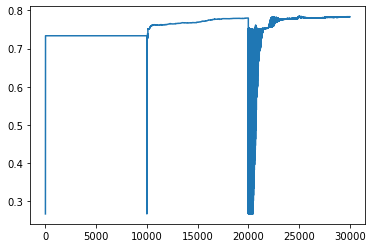

In [86]:
iterations = 10000
acc = gradient_descent(X_train, y_train, iterations, 0.0001)
plt.plot(acc)

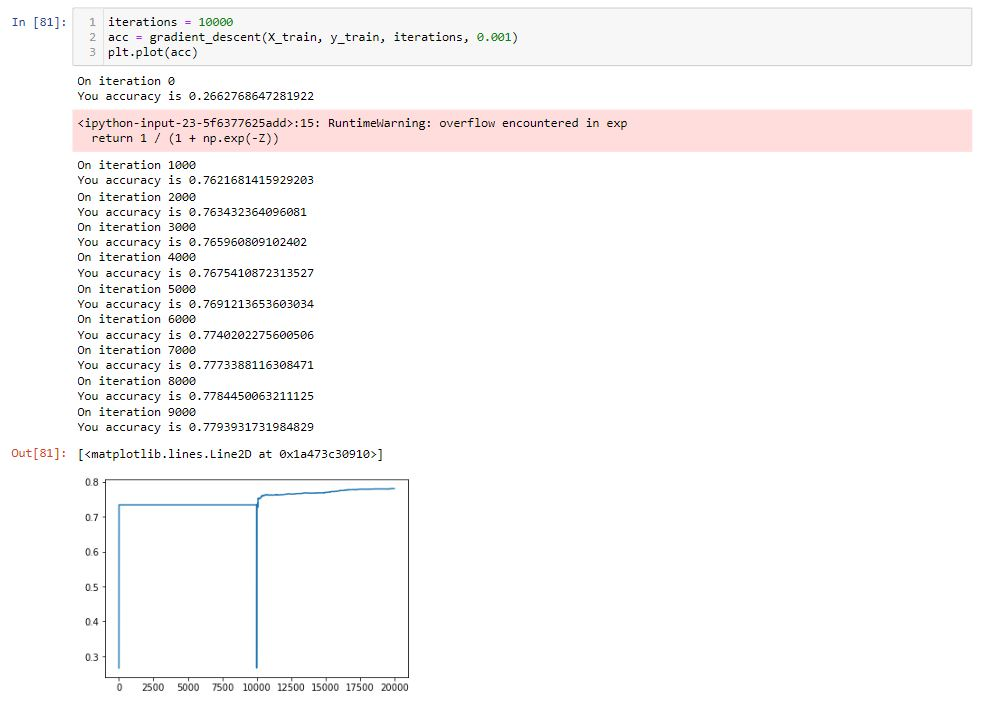

In [82]:
from IPython.display import Image
Image(filename='MLP from scratch.jpg') 